# Obtención Pixel Metro

### Imports

In [2]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np

### Obtener una imagen de mesa recortada

In [ ]:
b,g,r = cv2.split(cv2.imread("segmentation_masks/36.png"))
img = r
img = cv2.resize(img,(320,180))
thresh = cv2.threshold(img,128,255,cv2.THRESH_BINARY)[1]
contours,hierarchy = cv2.findContours(thresh, 1, 2)
for a in range(len(contours)):
    cnt = contours[0]
    x,y,w,h = cv2.boundingRect(cnt)
    if w<=5 or h<=5:
        continue
    img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,255,255),1)

In [ ]:
im = Image.open(r"./images/10000036.jpg")

In [ ]:
croped = im.crop((x*6, y*6, x*6+w*6 , y*6+h*6))

In [ ]:
croped.save("./table", "jpeg")

### Implementación

In [141]:
img = cv2.imread("./taula2.JPG")
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

kernel_size = 5
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
#ret,blur_gray = cv2.threshold(gray,120,255,cv2.THRESH_BINARY)

In [142]:
#blur_gray = imagen - gray
low_threshold = 50
high_threshold = 125
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
kernel = np.ones((10,10),np.uint8)
closing = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

In [143]:
rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 10  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 60  # minimum number of pixels making up a line
max_line_gap = 30  # maximum gap in pixels between connectable line segments
line_image = np.copy(img) * 0  # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(closing, rho, theta, threshold, np.array([]),min_line_length, max_line_gap)

for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),5)

In [144]:
lines_edges = cv2.addWeighted(img, 0.8, line_image, 1, 0)

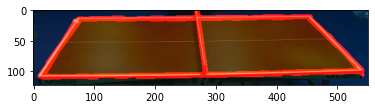

In [145]:
plt.imshow(lines_edges)

In [146]:
lines

array([[[ 10, 109, 541, 100]],

       [[136,  15, 456,  10]],

       [[ 15, 110, 541, 101]],

       [[ 73,  15, 332,  11]],

       [[170, 109, 408, 105]],

       [[221,  15, 457,  11]],

       [[ 73,  14, 148,  12]],

       [[ 10, 108,  79,  13]],

       [[410, 101, 541,  98]],

       [[453,  12, 541,  97]],

       [[269,   0, 284, 107]],

       [[454,  12, 530,  86]],

       [[ 23,  87,  76,  13]],

       [[455,  12, 520,  75]],

       [[486,  40, 542, 106]],

       [[194,  12, 278,  14]],

       [[270,   0, 285, 105]],

       [[ 11, 108,  80,  13]],

       [[268,   0, 283, 107]],

       [[ 11, 107, 105, 110]],

       [[373, 102, 442, 104]],

       [[263,  11, 342,  14]],

       [[ 71, 107, 155, 109]],

       [[451,  12, 541,  99]],

       [[129,  13, 214,  15]],

       [[333,  11, 411,  13]],

       [[378,  10, 448,  11]],

       [[ 16, 106,  70,  16]],

       [[ 18, 105,  67,  23]]], dtype=int32)

In [147]:
import math

def getMaxLine(lines):
    """
    Encuentra la linea más larga que será la de 2.74 m de la mesa
    """
    maxline = 0
    maxvalues = []
    m = 0
    for line in lines:
        for x1,y1,x2,y2 in line:
            dist = math.sqrt((x1-x2)**2 + (y1-y2)**2)
            if dist>maxline:
                maxline = dist
                maxvalues = [x1,y1,x2,y2]
    return maxvalues


def eraseDuplicates(lines, l, acc = 10):
    """
    Elimina las lineas repetidas
    """
    new_lines = []
    xl1,yl1,xl2,yl2 = l
    xm1,ym1,xm2,ym2 = l
    count = 1
    for line in lines:
        for x1,y1,x2,y2 in line:
            if (abs(x1 - xl1) <= acc) and (abs(y1 - yl1) <= acc):
                if (abs(x2 - xl2) <= acc) and (abs(y2 - yl2) <= acc):
                    xm1 += x1
                    ym1 += y1
                    xm2 += x2
                    ym2 += y2
                    count +=1
                    continue
            new_lines.append(line)
    return (np.array(new_lines),[int(xm1/count),int(ym1/count),int(xm2/count),int(ym2/count)])

                    
def getBestCorner(lines, l, right, acc = 0):
    """
    Encuentra las lineas paralelas a la dada sin devolver repeticiones
    """
    lines,_ = eraseDuplicates(lines, l)
    xl1,yl1,xl2,yl2 = l
    ml = (yl2 - yl1)/(xl2 - xl1)
    
    best_line = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            if right == True:
                if (abs(x1 - xl1) <= acc) and (abs(y1 - yl1) <= acc):
                    m = (y2 - y1)/(x2 - x1)
                    alpha = math.atan((ml - m)/(1+ml*m))* 180 / np.pi
                    if (alpha>25 and alpha<90) or (alpha < -45 and alpha > -90):
                        best_line.append([[x1,y1,x2,y2]])
            else:
                if (abs(x2 - xl2) <= acc) and (abs(y2 - yl2) <= acc):
                    m = (y2 - y1)/(x2 - x1)
                    alpha = math.atan((ml - m)/(1+ml*m))* 180 / np.pi
                    if (alpha<-20 and alpha>-90) or (alpha > 45 and alpha < 90):
                        best_line.append([[x1,y1,x2,y2]])
                    
    if best_line == []: #No ha encontrado linea buena
        return getBestCorner(lines, l, right, acc+1)
    else:
        return getMaxLine(np.array(best_line))

In [148]:
imagen = cv2.bilateralFilter(blur_gray,20,100,250)

In [149]:
getMaxLine(lines)

[10, 109, 541, 100]

In [150]:
getBestCorner(lines,getMaxLine(lines),True)

[10, 108, 79, 13]

In [151]:
getBestCorner(lines,getMaxLine(lines),False)

[451, 12, 541, 99]

In [152]:
x1,y1,x2,y2 = getMaxLine(lines)
cv2.line(img,(x1,y1),(x2,y2),(255,0,0),5);

x1,y1,xed,yed = getBestCorner(lines,getMaxLine(lines),True)
cv2.line(img,(x1,y1),(xed,yed),(255,0,0),5);

x1,y1,x2,y2 = getBestCorner(lines,getMaxLine(lines),False)
cv2.line(img,(x1,y1),(x2,y2),(255,0,0),5);

cv2.line(img,(xed,yed),(x1,y1),(255,0,0),5);

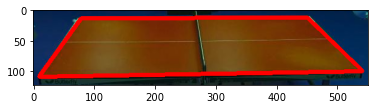

In [153]:
plt.imshow(img)

In [ ]:
#last line -> fer mitja de paralela, bestCorner 1 i 2 i connectar